In this notebook the Atlantic-Iberian Biscay Irish- Ocean Physics Reanalysis (netCDFs) data are imported and converted to dataframes.

It's perform visualizations of the data, application of Canny with and without the prior use of a Gaussian filter, overlay of the images with the edges detected by Canny, .... A slider is also created to evaluate how the detection of fronts varies with the variation of Thresholds values.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import cv2
import datetime
import xarray as xr
import os

%matplotlib inline

#### Importação dos dados de Atlantic-Iberian Biscay Irish- Ocean Physics Reanalysis

Através da command line eu importei uma base de dados relativa aos ultimos 10 dias dos valores de SST de um dado programa do Copernicus. Trata-se de um ficheiro .nc (netCDF)

No entanto no futuro eu vou querer que o meu programa faça download diretamente dos dados num python script

In [2]:
current_path = os.getcwd()
current_path

'/home/luisfigueiredo/JUNO/notebooks'

In [3]:
from pathlib import Path

data_folder = os.path.join(current_path,"../data")
data_folder

'/home/luisfigueiredo/JUNO/notebooks/../data'

In [4]:
nc_path = os.path.join(data_folder, "IBI2014-2019.nc")
ds = nc.Dataset(nc_path)
data = xr.load_dataset(nc_path)

In [5]:
print(ds)     # informações relativas ao ficheiro netCDF

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.0
    source: CMEMS IBI-MFC
    institution: Puertos del Estado (PdE) - Mercator-Ocean (MO)
    references: http://marine.copernicus.eu
    title: CMEMS IBI REANALYSIS: DAILY PHYSICAL PRODUCTS 
    easting: longitude
    northing: latitude
    domain_name: IBI12
    FROM_ORIGINAL_FILE__field_type: mean
    field_date: 20191224
    FROM_ORIGINAL_FILE__longitude_min: -19.f
    FROM_ORIGINAL_FILE__longitude_max: 5.f
    FROM_ORIGINAL_FILE__latitude_min: 26.f
    FROM_ORIGINAL_FILE__latitude_max: 56.f
    z_min: 0.50576f
    z_max: 5698.061f
    contact: mailto: servicedesk.cmems@mercator-ocean.eu
    bulletin_date: 2020-12-01
    bulletin_type: Reanalysis
    _CoordSysBuilder: ucar.nc2.dataset.conv.CF1Convention
    comment: 
    history: Data extracted from dataset http://localhost:8080/thredds/dodsC/cmems_mod_ibi_phy_my_0.083deg-3D_P1D-m
    dimensions(sizes): depth(1), latitude(1

In [6]:
#Converter o ficheiro netCDF para uma dataframe
datadf = data.to_dataframe()
datadf2 = datadf.reset_index()

In [7]:
datadf2 = datadf2.drop(['depth'], axis=1)     #dropar coluna 'depth' (não é necessária pq é sempre igual)
datadf2    #os dados .nc estão agora no formato de uma dataframe

,latitude,longitude,time,thetao
0,35.0,-19.0,2014-01-01 12:00:00,18.316000
1,35.0,-19.0,2014-01-02 12:00:00,18.309000
2,35.0,-19.0,2014-01-03 12:00:00,18.316000
3,35.0,-19.0,2014-01-04 12:00:00,18.273001
4,35.0,-19.0,2014-01-05 12:00:00,18.230000
...,...,...,...,...
44660611,45.0,-5.0,2019-12-20 12:00:00,13.619000
44660612,45.0,-5.0,2019-12-21 12:00:00,13.559000
44660613,45.0,-5.0,2019-12-22 12:00:00,13.458000
44660614,45.0,-5.0,2019-12-23 12:00:00,13.400000


In [8]:
datadf2 = datadf2[['time', 'latitude', 'longitude', 'thetao']]    #reorganizar as colunas da dataframe
datadf2

,time,latitude,longitude,thetao
0,2014-01-01 12:00:00,35.0,-19.0,18.316000
1,2014-01-02 12:00:00,35.0,-19.0,18.309000
2,2014-01-03 12:00:00,35.0,-19.0,18.316000
3,2014-01-04 12:00:00,35.0,-19.0,18.273001
4,2014-01-05 12:00:00,35.0,-19.0,18.230000
...,...,...,...,...
44660611,2019-12-20 12:00:00,45.0,-5.0,13.619000
44660612,2019-12-21 12:00:00,45.0,-5.0,13.559000
44660613,2019-12-22 12:00:00,45.0,-5.0,13.458000
44660614,2019-12-23 12:00:00,45.0,-5.0,13.400000


In [9]:
#Df com dados relativos a um dia específico (neste caso 20 Setembro)
dia25 = datadf2[datadf2['time'] == '2019-09-25 12:00:00']
dia25

,time,latitude,longitude,thetao
2093,2019-09-25 12:00:00,35.0,-19.000000,22.527000
4277,2019-09-25 12:00:00,35.0,-18.916666,22.516001
6461,2019-09-25 12:00:00,35.0,-18.833334,22.648001
8645,2019-09-25 12:00:00,35.0,-18.750000,22.809002
10829,2019-09-25 12:00:00,35.0,-18.666666,22.910000
...,...,...,...,...
44651789,2019-09-25 12:00:00,45.0,-5.333334,19.063999
44653973,2019-09-25 12:00:00,45.0,-5.250000,19.021999
44656157,2019-09-25 12:00:00,45.0,-5.166667,18.996000
44658341,2019-09-25 12:00:00,45.0,-5.083334,19.000999


### 1º Plot do Mapa da SST

Através da dataframe relativa a um dia específico será criada uma pivot_table e depois será plotada uma contour para vermos o respetivo mapa da SST

In [10]:
#dropar a coluna relativa ao time (não é necessária)
dia25 = dia25.drop(['time'], axis=1)
dia25

,latitude,longitude,thetao
2093,35.0,-19.000000,22.527000
4277,35.0,-18.916666,22.516001
6461,35.0,-18.833334,22.648001
8645,35.0,-18.750000,22.809002
10829,35.0,-18.666666,22.910000
...,...,...,...
44651789,45.0,-5.333334,19.063999
44653973,45.0,-5.250000,19.021999
44656157,45.0,-5.166667,18.996000
44658341,45.0,-5.083334,19.000999


In [11]:
#Converter a df para uma pivot table par 
Temp = dia25.pivot_table(index='longitude', columns='latitude', values='thetao').T.values

long_unique = np.sort(dia25['longitude'].unique())
lat_unique = np.sort(dia25['latitude'].unique())
X, Y = np.meshgrid(long_unique, lat_unique)

In [12]:
Temp.shape #por este Temp dentro do Canny

(121, 169)

/tmp/ipykernel_5395/80628514.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


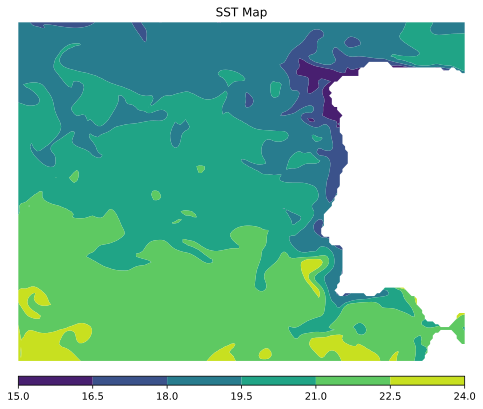

In [13]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

plt.rcParams['figure.figsize'] = 8,7 # sets plot size
fig = plt.figure()
ax = fig.add_subplot(111)

# Generate a color mapping of the levels we've specified
import matplotlib.cm as cm # matplotlib's color map library
cpf = ax.contourf(X,Y,Temp, 5, cmap=cm.viridis)

plt.axis('off');         #Para remover da imagem os labels com a longitude e latitude
plt.colorbar(cpf, orientation='horizontal', fraction=0.07, pad=0.04, aspect=50);
plt.title('SST Map');
 

## --------------------------------------------------------------------------------------------------------------
## Apply Canny to array in format uint8, with values between 0 and 255


In [24]:
def canny_visualization(df, Tmax):
    
    """
    Função que pega numa df com as temperaturas relativas a um certo dia e plota um mapa com as edges definidas
    através do Canny Algorithm
    """
    
    plt.rcParams["figure.figsize"] = 6, 6
    
    #Pegar na df dum dia e converte-la num np array com os valores de Temperatura para os valores de long e lati
    Temp = df.pivot_table(index='longitude', columns='latitude', values='thetao').T.values
    
    #Converter os valores de temperatura no formato uint8 com valores entre 0-255
    Temp_day = ((Temp - np.nanmin(Temp)) * (1/(np.nanmax(Temp) - np.nanmin(Temp)) * 255)).astype('uint8')

    Temp_day = np.flipud(Temp_day)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    
    #apply the canny algorithm and plot the image with the edges
    canny = cv2.Canny(Temp_day, Tmax/2, Tmax, L2gradient=False, apertureSize=3)
    plt.imshow(canny, 'gray')    #'gray'-> parametro para por a preto e branco
    plt.axis('off');


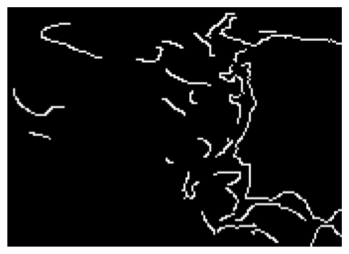

In [25]:
canny_visualization(dia25, 180)

In [26]:
# Matriz de temperatura em que os valores estão entre 0 e 255
Temp_aux5 = ((Temp - np.nanmin(Temp)) * (1/(np.nanmax(Temp) - np.nanmin(Temp)) * 255)).astype('uint8')
Temp_aux5 = np.flipud(Temp_aux5)  
Temp_aux5

array([[124, 124, 116, ..., 117, 117, 118],
       [123, 124, 122, ..., 119, 119, 120],
       [119, 121, 122, ..., 120, 120, 120],
       ...,
       [228, 226, 230, ...,   0,   0,   0],
       [228, 227, 231, ...,   0,   0,   0],
       [228, 227, 231, ...,   0,   0,   0]], dtype=uint8)

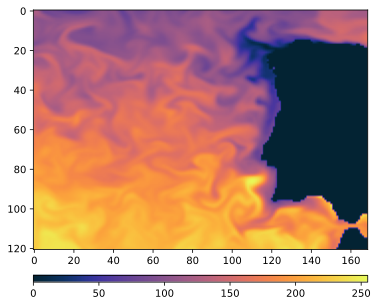

In [27]:
#Plotar o numpy array para ver se de facto corresponde há imagem em causa
im3 = plt.imshow(Temp_aux5, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = (7,7)
plt.colorbar(im3, orientation='horizontal', fraction=0.07, pad=0.08, aspect=50)
plt.show()

#### Imagens na mesma célula para facilitar interpretação

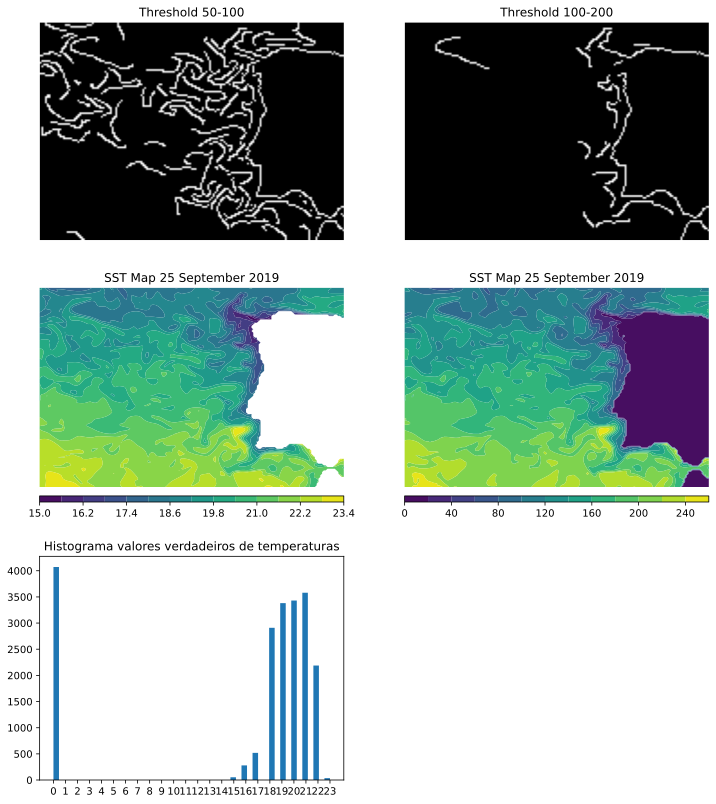

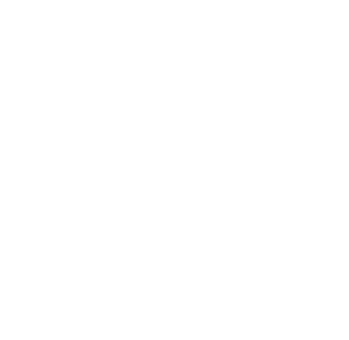

In [28]:
# create figure
fig = plt.figure(figsize=(12, 14))

# setting values to rows and column variables
rows = 3
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
#Definição dos parametros do canny
Tmax = 100
Tmin= Tmax/2
canny_visualization(dia25, Tmax)
plt.title("Threshold 50-100");

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
canny_visualization(dia25, 2*Tmax)
plt.title("Threshold 100-200");


# Adds a subplot to show the image
ax = fig.add_subplot(rows, columns, 3)
cpf = ax.contourf(X,Y,Temp, 14, cmap=cm.viridis)
plt.axis('off');       #Para remover da imagem os labels com a longitude e latitude
plt.colorbar(cpf, orientation='horizontal', fraction=0.07, pad=0.04, aspect=50)
plt.title('SST Map 25 September 2019');


# Adds a subplot at tshow um histograma com a dispersão dos valores de temperatura na matriz da imagem
ax = fig.add_subplot(rows, columns, 4)
cpf = ax.contourf(X,Y,np.flipud(Temp_aux5), 14, cmap=cm.viridis)
plt.axis('off');       #Para remover da imagem os labels com a longitude e latitude
plt.colorbar(cpf, orientation='horizontal', fraction=0.07, pad=0.04, aspect=50)
plt.title('SST Map 25 September 2019');


# Adds a subplot at tshow um histograma com a dispersão dos valores de temperatura na matriz da imagem
fig.add_subplot(rows, columns, 5)
histograma = plt.hist(Temp_aux.flatten(), bins=50);
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
# showing image
plt.title("Histograma valores verdadeiros de temperaturas");
plt.show(histograma);
plt.axis('off');

# Adds a subplot at tshow um histograma com a dispersão dos valores de temperatura na matriz da imagem
#fig.add_subplot(rows, columns, 6)
#histograma255 = plt.hist(Temp_aux5.flatten(), bins=100);
#plt.xlim([0, 255])
#plt.ylim([0, 500])
# showing image
#plt.title("Histograma temperaturas na gama 0-255");
#plt.show(histograma255);
#plt.axis('off');


# ---------------------------------------------------------------------------------------------------
## Canny with Gaussian Filter previously applied

No paper de Madagascar eles dizem aplicar um gaussian filter às imagens antes de aplicar o Canny Algorithm (to omit small scale variability).

Desfoca as imagens um pouco

In [29]:
from scipy.ndimage import gaussian_filter

In [30]:
Temp_gauss = Temp_aux5.copy()
Temp_gauss

array([[124, 124, 116, ..., 117, 117, 118],
       [123, 124, 122, ..., 119, 119, 120],
       [119, 121, 122, ..., 120, 120, 120],
       ...,
       [228, 226, 230, ...,   0,   0,   0],
       [228, 227, 231, ...,   0,   0,   0],
       [228, 227, 231, ...,   0,   0,   0]], dtype=uint8)

In [31]:
Temp_gauss = gaussian_filter(Temp_gauss, sigma=1)  #Sigma -> Standard deviation for Gaussian kernel.
Temp_gauss
#Quando aplico este Gaussian_filter a gama de valores do array passa a estar entre 0-229

array([[122, 120, 115, ..., 117, 117, 117],
       [121, 120, 116, ..., 118, 118, 118],
       [117, 118, 117, ..., 120, 120, 120],
       ...,
       [227, 228, 230, ...,   0,   0,   0],
       [227, 228, 230, ...,   0,   0,   0],
       [227, 228, 230, ...,   0,   0,   0]], dtype=uint8)

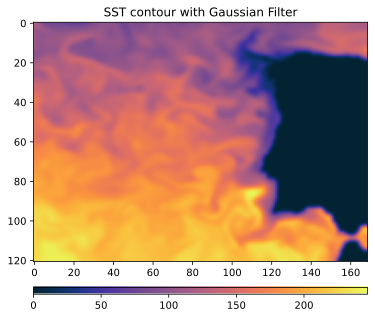

In [32]:
#Plotar o numpy array para ver se de facto corresponde há imagem em causa
im5 = plt.imshow(Temp_gauss, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = (7,7)
plt.colorbar(im5, orientation='horizontal', fraction=0.07, pad=0.08, aspect=50)
plt.title('SST contour with Gaussian Filter')
plt.show()

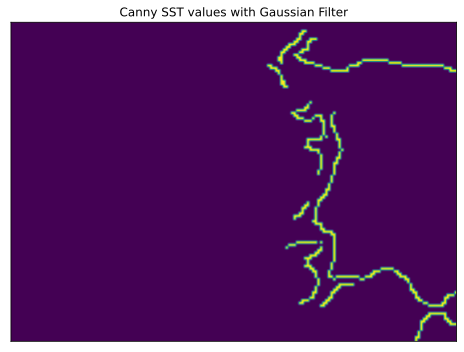

In [33]:
canny_gauss = cv2.Canny(Temp_gauss, 90, 180, L2gradient=False, apertureSize=3)

plt.rcParams["figure.figsize"] = (8,8)

plt.imshow(canny_gauss)    #'gray'-> parametro para por a preto e branco
plt.title('Canny SST values with Gaussian Filter')
plt.xticks([])
plt.yticks([])
    
plt.show()

#### Mostrar diferença de resultados: Normal vs Prévia aplicação dum Gaussian Filter

Podemos observar as diferenças que surgem nos resultados do canny quando é previamente aplicado um Gaussian Filter ao array.  Gaussian filter is commonly used in image processing for smoothing and reducing noise.

No StackOverflow dizem que se usarmos um apertureSize superior a 3 (5 ou 7) então não é necessário aplicar um Gaussian Blur. Se se usar um apertureSize=3 então é necessário aplicar previamente um Gaussian Blur. Existem algumas fontes que contradizem esta informação.

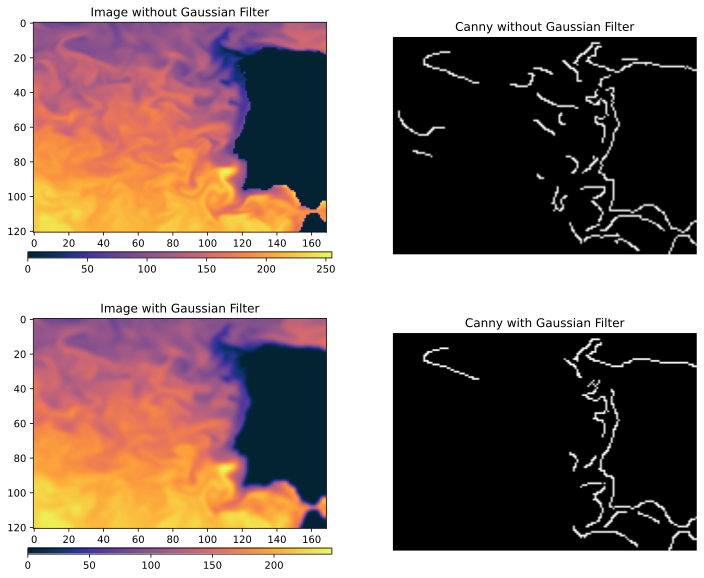

In [34]:
# create figure
fig = plt.figure(figsize=(12, 10))

# setting values to rows and column variables
rows = 2
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
im3 = plt.imshow(Temp_aux5, cmocean.cm.thermal);
plt.colorbar(im3, orientation='horizontal', fraction=0.07, pad=0.08, aspect=50);
plt.title('Image without Gaussian Filter');


# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
canny_visualization(dia25, 180)
plt.title("Threshold 90-180");
plt.title("Canny without Gaussian Filter");


# Adds a subplot to show the image
ax = fig.add_subplot(rows, columns, 3)
im5 = plt.imshow(Temp_gauss, cmocean.cm.thermal)
plt.colorbar(im5, orientation='horizontal', fraction=0.07, pad=0.08, aspect=50)
plt.title('Image with Gaussian Filter');

# Adds a subplot at tshow um histograma com a dispersão dos valores de temperatura na matriz da imagem
fig.add_subplot(rows, columns, 4)
#Definição dos parametros do canny
canny7 = cv2.Canny(Temp_gauss, 75, 150, L2gradient=False, apertureSize=3)
#apertureSize -> Order of Kernel(matrix) for the Sobel filter. Default value is (3 x 3). value should be odd between 3 and 7
#L2gradient -> specifies the equation for finding gradient magnitude. If True uses a more accurate equation; Default value is False
# With L2gradient=True the algorithm shows less edges
plt.imshow(canny7, 'gray')   
plt.axis('off');
plt.title('Canny with Gaussian Filter');


# ----------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------
## Fazer o overlay das imagens com os edges do Canny

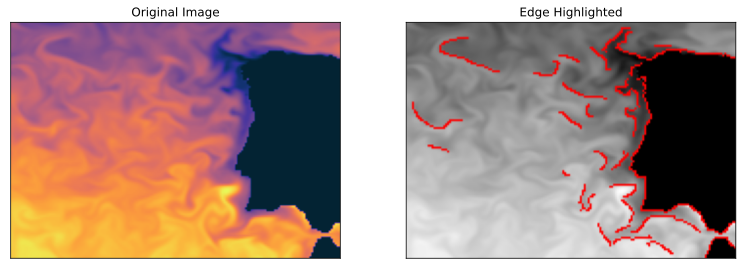

In [35]:

img = Temp_aux5
edges = cv2.Canny(Temp_aux5, 90, 180)   # canny edge detector

fig = plt.subplots(figsize=(13,10))
#plt.rcParams["figure.figsize"] = 12, 20

img = cv2.merge((img,img,img))  # creat RGB image from grayscale
img2 = img.copy()
img2[edges == 255] = [255, 0, 0]  # turn edges to red

plt.subplot(121),plt.imshow(Temp_aux5, cmocean.cm.thermal)
plt.title('Original Image'), plt.xticks([]), plt.yticks([]);
plt.subplot(122),plt.imshow(img2)
plt.title('Edge Highlighted'), plt.xticks([]), plt.yticks([])

plt.show()

In [ ]:
#Este overlay esta a ser aplicado sobre uma imagem de fronts sobre a qual não foi aplicada um Gaussian Filter

# ---------------------------------------------------------------------------
### Finding Oceanic fronts with Edge Detection Techniques

Com este código é possível avaliar como varia a deteção de frentes com a variação dos valores do Threshold

In [36]:
from IPython.display import display
from IPython.html.widgets import interact, fixed

#cbarkw = dict(shrink=0.73, extend='both')

def canny_threshold(image, threshold=50, ratio=3, ksize=3):
    
    #apply canny algorithm
    detected_edges = cv2.Canny(Temp_aux5, threshold,
                               threshold*ratio,
                               apertureSize=ksize)
    # Just add some colours to edges from original data.
    mask = np.ma.masked_equal(detected_edges, 0).mask
    img = np.ma.masked_array(Temp_aux5, mask)
    
    fig, ax = plt.subplots(figsize=(10,8))
    cs = ax.imshow(img)
    #cbar = fig.colorbar(cs, ax=ax, **cbarkw)
    ax.axis('off')
    plt.show()

lims = (0, 100)
w = interact(canny_threshold, threshold=lims,
             image=fixed(Temp_aux5),
             ratio=fixed(3), ksize=fixed(3))

display(w)

interactive(children=(IntSlider(value=50, description='threshold'), Output()), _dom_classes=('widget-interact'…

<function __main__.canny_threshold(image, threshold=50, ratio=3, ksize=3)>

In [37]:
Temp_aux5

array([[124, 124, 116, ..., 117, 117, 118],
       [123, 124, 122, ..., 119, 119, 120],
       [119, 121, 122, ..., 120, 120, 120],
       ...,
       [228, 226, 230, ...,   0,   0,   0],
       [228, 227, 231, ...,   0,   0,   0],
       [228, 227, 231, ...,   0,   0,   0]], dtype=uint8)

# ---------------------------------------------------------------------------------------
## Otsu Method
Is an algorithm to automatically find the optimal threshold intensity

It searches for the threshold intensity that optimally separates the image into two classes (the foreground and the background). Does this by maximizing a matrix called between class variance.
Is optimal in the sense that it does the best possible job to split the foreground and the background assuming a bi-modal distribution of grayscale pixel values.

The Otsu algorithm calculate the high threshold, and then it can be used in the Canny algorithm to detect the object’s edge

Otsu method makes the assumption that the grayscalle histogram of our pixel intensities of our image is bi-modal (the histogram has 2 peaks) --> o que no caso da nossa imagem não é verdade.
If it doesn't follow a bi-modal distribution the Otsu's method may not give us the best results. 

So we should try Adaptive thresholding.

In situations where lighting conditions are semi-stable and the objects we want to segment have sufficient contrast from the background we might not need to use Otsu's method.

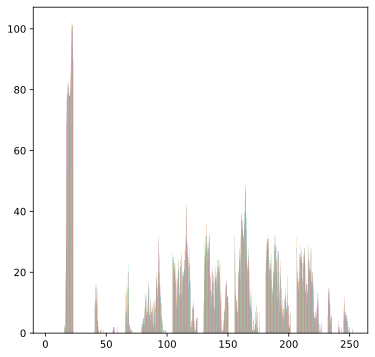

In [48]:
plt.hist(Temp_aux5);

In [49]:
bins_num = 256

#Get the image histogram
hist, bin_edges = np.histogram(Temp_aux5, bins=bins_num)

#Calculate centers of Bins
bin_mids = (bin_edges[:-1] + bin_edges[1:])/2

#iterate through all thresholds (indices) and get the probabilities w1(t), w2(t)
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

#Get the class means mu0(t)
mean1 = np.cumsum(hist*bin_mids)/weight1
#get the class means mu1(t)
mean2 = (np.cumsum((hist*bin_mids)[::-1])/weight2[::-1])[::-1]

inter_class_variance = weight1[:-1]*weight2[1:]*(mean1[:-1] - mean2[1:])**2

#Maximize the inter_class_variance function val
index_of_max_val = np.argmax(inter_class_variance)

threshold = bin_mids[:-1][index_of_max_val]
print('Otsu algorithm implementation thresholding result: ', threshold)

Otsu algorithm implementation thresholding result:  86.162109375


In [50]:
#Outra forma de obter o Otsu's thresolding atraves do openCV
otsu_threshold, image_result = cv2.threshold(Temp_aux5, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
print('Obtained threshold: ', otsu_threshold)

Obtained threshold:  86.0


In [ ]:
#Estes valores (86) correspondem ao threshold high.
# Ao variarmos os dias vão variar estes valores portanto...